<a href="https://colab.research.google.com/github/Shrutiya/Image-Caption-Generator/blob/main/predict_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import cv2
import skimage

import tensorflow.python.platform
from scipy.misc import imread, imresize
from keras.preprocessing import sequence
from collections import Counter

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 124kB/s 
ERROR: tensorflow 2.2.0rc3 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!pip install numpy==1.16.1
import numpy as np

     |████████████████████████████████| 17.3MB 246kB/s 
ERROR: tensorflow 2.2.0rc3 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = 'drive/My Drive/TDLProj/FINAL_200'

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras import Model

model = VGG16()
model.layers.pop()
#model.layers.pop()
model=Model(inputs=model.inputs,outputs=model.layers[-1].output)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________

In [ ]:
img_path = 'drive/My Drive/TDLProj/IMG-20200229-WA0003.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)
vgg16_feature = model.predict(img_data)
feat=vgg16_feature
print(feat.shape)


(1, 4096)


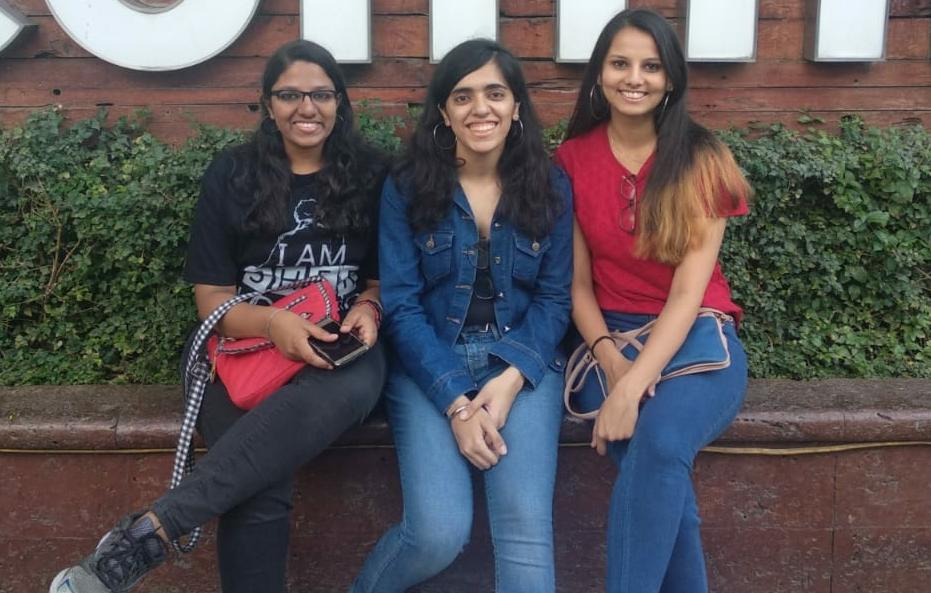

In [ ]:
from IPython.display import Image
Image('drive/My Drive/TDLProj/IMG-20200229-WA0003.jpg')

In [ ]:
dim_embed = 256
dim_hidden = 256
dim_in = 4096
batch_size = 1
learning_rate = 0.001
momentum = 0.9
n_epochs = 25

In [ ]:
class Caption_Generator():
    def __init__(self, dim_in, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, init_b=None):

        self.dim_in = dim_in
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.n_lstm_steps = n_lstm_steps
        self.n_words = n_words
        
        # declare the variables to be used for our word embeddings
        with tf.device("/cpu:0"):
            self.word_embedding = tf.Variable(tf.random_uniform([self.n_words, self.dim_embed], -0.1, 0.1), name='word_embedding')

        self.embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='embedding_bias')
        
        # declare the LSTM itself
        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden)
        
        # declare the variables to be used to embed the image feature embedding to the word embedding space
        self.img_embedding = tf.Variable(tf.random_uniform([dim_in, dim_hidden], -0.1, 0.1), name='img_embedding')
        self.img_embedding_bias = tf.Variable(tf.zeros([dim_hidden]), name='img_embedding_bias')

        # declare the variables to go from an LSTM output to a word encoding output
        self.word_encoding = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='word_encoding')
        
        # optional initialization setter for encoding bias variable 
        if init_b is not None:
            self.word_encoding_bias = tf.Variable(init_b, name='word_encoding_bias')
        else:
            self.word_encoding_bias = tf.Variable(tf.zeros([n_words]), name='word_encoding_bias')

    def build_model(self):
        # declaring the placeholders for our extracted image feature vectors, our caption, and our mask
        # (describes how long our caption is with an array of 0/1 values of length `maxlen`  
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        caption_placeholder = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])
        
        # getting an initial LSTM embedding from our image_imbedding
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        
        # setting initial state of our LSTM
        state = self.lstm.zero_state(self.batch_size, dtype=tf.float32)

        total_loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): 
                if i > 0:
                   # if this isn’t the first iteration of our LSTM we need to get the word_embedding corresponding
                   # to the (i-1)th word in our caption 
                    with tf.device("/cpu:0"):
                        current_embedding = tf.nn.embedding_lookup(self.word_embedding, caption_placeholder[:,i-1]) + self.embedding_bias
                else:
                     #if this is the first iteration of our LSTM we utilize the embedded image as our input 
                    current_embedding = image_embedding
                if i > 0: 
                    # allows us to reuse the LSTM tensor variable on each iteration
                    tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(current_embedding, state)

                
                if i > 0:
                    #get the one-hot representation of the next word in our caption 
                    labels = tf.expand_dims(caption_placeholder[:, i], 1)
                    ix_range=tf.range(0, self.batch_size, 1)
                    ixs = tf.expand_dims(ix_range, 1)
                    concat = tf.concat([ixs, labels],1)
                    onehot = tf.sparse_to_dense(
                            concat, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0)


                    #perform a softmax classification to generate the next word in the caption
                    logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=onehot)
                    xentropy = xentropy * mask[:,i]

                    loss = tf.reduce_sum(xentropy)
                    total_loss += loss

            total_loss = total_loss / tf.reduce_sum(mask[:,1:])
            return total_loss, img,  caption_placeholder, mask


    def build_generator(self, maxlen, batchsize=1):
        #same setup as `build_model` function 
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_in])
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        state = self.lstm.zero_state(batchsize,dtype=tf.float32)

        #declare list to hold the words of our generated captions
        all_words = []
        with tf.variable_scope("RNN"):
            # in the first iteration we have no previous word, so we directly pass in the image embedding
            # and set the `previous_word` to the embedding of the start token ([0]) for the future iterations
            output, state = self.lstm(image_embedding, state)
            previous_word = tf.nn.embedding_lookup(self.word_embedding, [0]) + self.embedding_bias

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                out, state = self.lstm(previous_word, state)


                # get a get maximum probability word and it's encoding from the output of the LSTM
                logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                best_word = tf.argmax(logit, 1)

                with tf.device("/cpu:0"):
                    # get the embedding of the best_word to use as input to the next iteration of our LSTM 
                    previous_word = tf.nn.embedding_lookup(self.word_embedding, best_word)

                previous_word += self.embedding_bias

                all_words.append(best_word)

        return img, all_words

In [ ]:
tf.reset_default_graph()
'''with open(vgg_path,'rb') as f:
    fileContent = f.read()
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(fileContent)

images = tf.placeholder("float32", [1, 224, 224, 3])
tf.import_graph_def(graph_def, input_map={"images":images})'''

ixtoword = np.load('drive/My Drive/TDLProj/ixtoword.npy').tolist()
n_words = len(ixtoword)
maxlen=15
graph = tf.get_default_graph()
sess = tf.InteractiveSession(graph=graph)
caption_generator = Caption_Generator(dim_in, dim_hidden, dim_embed, batch_size, maxlen+2, n_words)
graph = tf.get_default_graph()

imagee, generated_words = caption_generator.build_generator(maxlen=maxlen)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
def test(sess,image,generated_words,ixtoword,feat): # Naive greedy search

    

    #feat = read_image(test_image_path)
    #fc7 = sess.run(graph.get_tensor_by_name("import/Relu_1:0"), feed_dict={images:feat})

    saver = tf.train.Saver()
    sanity_check=False
    # sanity_check=True
    if not sanity_check:
        saved_path=tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)
    else:
        tf.global_variables_initializer().run()

    generated_word_index= sess.run(generated_words, feed_dict={image:feat})
    generated_word_index = np.hstack(generated_word_index)
    generated_words = [ixtoword[x] for x in generated_word_index]
    punctuation = np.argmax(np.array(generated_words) == '.')+1

    generated_words = generated_words[:punctuation]
    generated_sentence = ' '.join(generated_words)
    print(generated_sentence)

In [ ]:
test(sess,imagee,generated_words,ixtoword,feat)

INFO:tensorflow:Restoring parameters from drive/My Drive/TDLProj/FINAL_200/model-152
two women and a man are smiling and walking in a park .


In [ ]:
countzero_in1 = np.count_nonzero(feat)
print(countzero_in1)

1000
